# Montecarlo Approximation of Electron-Matter-Interaction

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from fastai.vision.all import * 
import fastai
import torch
print("sys.version", sys.version)
print("cuda device name(0)", torch.cuda.get_device_name(0))
print("torch.__version__", torch.__version__)
print("fastai.__version__", fastai.__version__)

sys.version 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
cuda device name(0) Tesla V100S-PCIE-32GB
torch.__version__ 1.7.1
fastai.__version__ 2.7.4


In [3]:
import pathlib
input_path = Path('./data')

def get_items(input_path):
    file_names = get_image_files(input_path)
    file_names = [filename for filename in file_names if "_hf.tif" in str( filename ) ]
    return file_names
    
file_names = get_items(input_path)    
print(file_names[0:5])

[Path('data/cox_boolean_1000_0p6_0p1_15_25_850x850x1030_BSE_130_hf.tif'), Path('data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_65_hf.tif'), Path('data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_5_hf.tif'), Path('data/cox_boolean_1000_0p6_0p1_15_25_850x850x1030_BSE_170_hf.tif'), Path('data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_35_hf.tif')]


## Datensatz laden

In [4]:
def get_hf(filename):
    filename_parts = str(filename.stem).split("_")
    y = input_path / Path( "_".join(filename_parts[:-1]) + "_hf.tif" )
    return str(y)

def get_normal(filename):
    filename_parts = str(filename.stem).split("_")
    y = input_path / Path( "_".join(filename_parts[:-1]) + "_normal.tif" )
    return str(y)

def get_bse(filename):
    filename_parts = str(filename.stem).split("_")
    y = input_path / Path( "_".join(filename_parts[:-1]) + "_bse.tif" )
    return str(y)

for i in range(5):
    print(file_names[i], "/", get_normal(file_names[i]), "/", get_bse(file_names[i]))

data/cox_boolean_1000_0p6_0p1_15_25_850x850x1030_BSE_130_hf.tif / data/cox_boolean_1000_0p6_0p1_15_25_850x850x1030_BSE_130_normal.tif / data/cox_boolean_1000_0p6_0p1_15_25_850x850x1030_BSE_130_bse.tif
data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_65_hf.tif / data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_65_normal.tif / data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_65_bse.tif
data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_5_hf.tif / data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_5_normal.tif / data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_5_bse.tif
data/cox_boolean_1000_0p6_0p1_15_25_850x850x1030_BSE_170_hf.tif / data/cox_boolean_1000_0p6_0p1_15_25_850x850x1030_BSE_170_normal.tif / data/cox_boolean_1000_0p6_0p1_15_25_850x850x1030_BSE_170_bse.tif
data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_35_hf.tif / data/Boolean_Fiber_450_4p5em6_10_10_15_100_220_425x425x480_BSE_35_norm

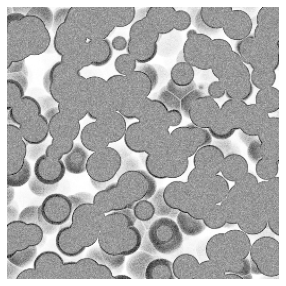

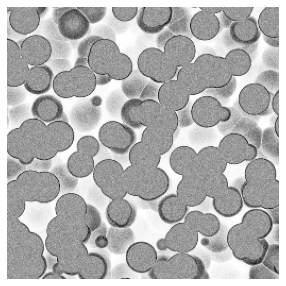

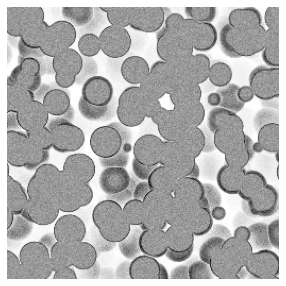

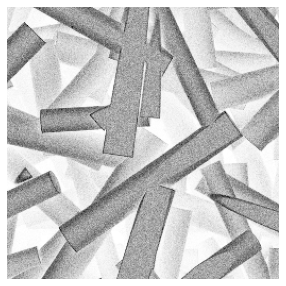

In [5]:
item_transforms  = [RandomCrop((256,256)),DihedralItem]

datablocks = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock, ImageBlock(cls=PILImageBW)),
                       n_inp=2,
                       get_items=get_items,
                       getters=[get_hf,get_normal,get_bse],
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       item_tfms=item_transforms)

data_loader = datablocks.dataloaders(input_path, bs=4, num_workers=0 )

data_loader.show_batch( max_n=8 )

# Netzwerk Architektur

In [6]:
def create_inner_model( dataloader, backbone, **kwargs ):
    img_size = dataloader.one_batch()[0].shape[-2:]
    model = create_unet_model(backbone, 1, img_size, **kwargs)
    return model

class FIBModel(torch.nn.Module):
    def __init__(self, inner_model):
        super().__init__()
        self.inner_model = inner_model
        
    def forward(self, x_hf, x_normal):
        x = x_normal
        x[:,2,:,:] = x_hf[:,0,:,:]
        return self.inner_model(x)

## Determine Learning Rate

In [7]:
# learner.save("custom_initial")
# learner.lr_find()

In [8]:
learning_rate=0.001

## Adding noise

In [9]:
from skimage.util import random_noise

def add_noise( img, var ):
    return torch.tensor( random_noise(img, mode='gaussian', mean=0, var=var, clip=True) )

def estimate_snr( img ):
    return img.mean() / img.std();

## Cost Function

In [10]:
from torch.nn.functional import l1_loss
from torch.nn.modules.loss import _Loss

class NoisePreservingLossBase(_Loss):
    __constants__ = ['reduction']

    def __init__(self, alpha=1.0, size_average=None, reduce=None, reduction = 'mean'):        
        super(NoisePreservingLossBase, self).__init__(size_average, reduce, reduction)
        self.alpha=alpha

    def forward(self, y, yhat):
        y = y.flatten()
        yhat = yhat.flatten()
        dataterm = l1_loss( y, yhat, reduction=self.reduction)
        snr_y = estimate_snr( y )
        snr_yhat = estimate_snr( yhat )
        noiseterm = (snr_yhat-snr_y).abs()
        loss = dataterm + self.alpha * noiseterm
        return loss
    
    
def NoisePreservingLoss(
    *args, 
    axis=-1,
    floatify=True,
    **kwargs
):
    return BaseLoss(NoisePreservingLossBase, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)    

## Training 

resnet101


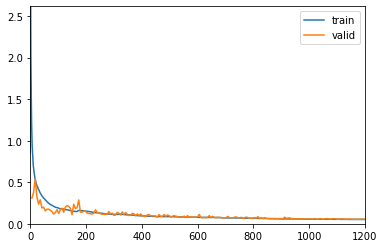

[0.052318356931209564, 0.05586624518036842]


In [11]:
from torchvision.models import *

train = True

# for backbone, backbone_name in [ (resnet101, "resnet101"), (resnet34,"resnet34"), (resnet50,"resnet50") ]:
for backbone, backbone_name in [ (resnet101, "resnet101") ]:
    print(backbone_name)
    model = FIBModel( create_inner_model( data_loader, backbone ) )
    learner = Learner( data_loader, model, loss_func=NoisePreservingLoss(alpha=0.1) )
    if train:
        learner.fit_one_cycle( 200, lr_max=learning_rate, cbs=[ShowGraphCallback()] )    
        learner.save(backbone_name + "200")
    else:
        learner.load(backbone_name + "200")
        
    # learner.fit_one_cycle( 50, lr_max=learning_rate, cbs=[ShowGraphCallback()] )    
    # leaner.save(backbone_name + "100")
    # learner.fit_one_cycle( 100, lr_max=learning_rate, cbs=[ShowGraphCallback()] )    
    # leaner.save(backbone_name + "200")
    print( learner.recorder.final_record )

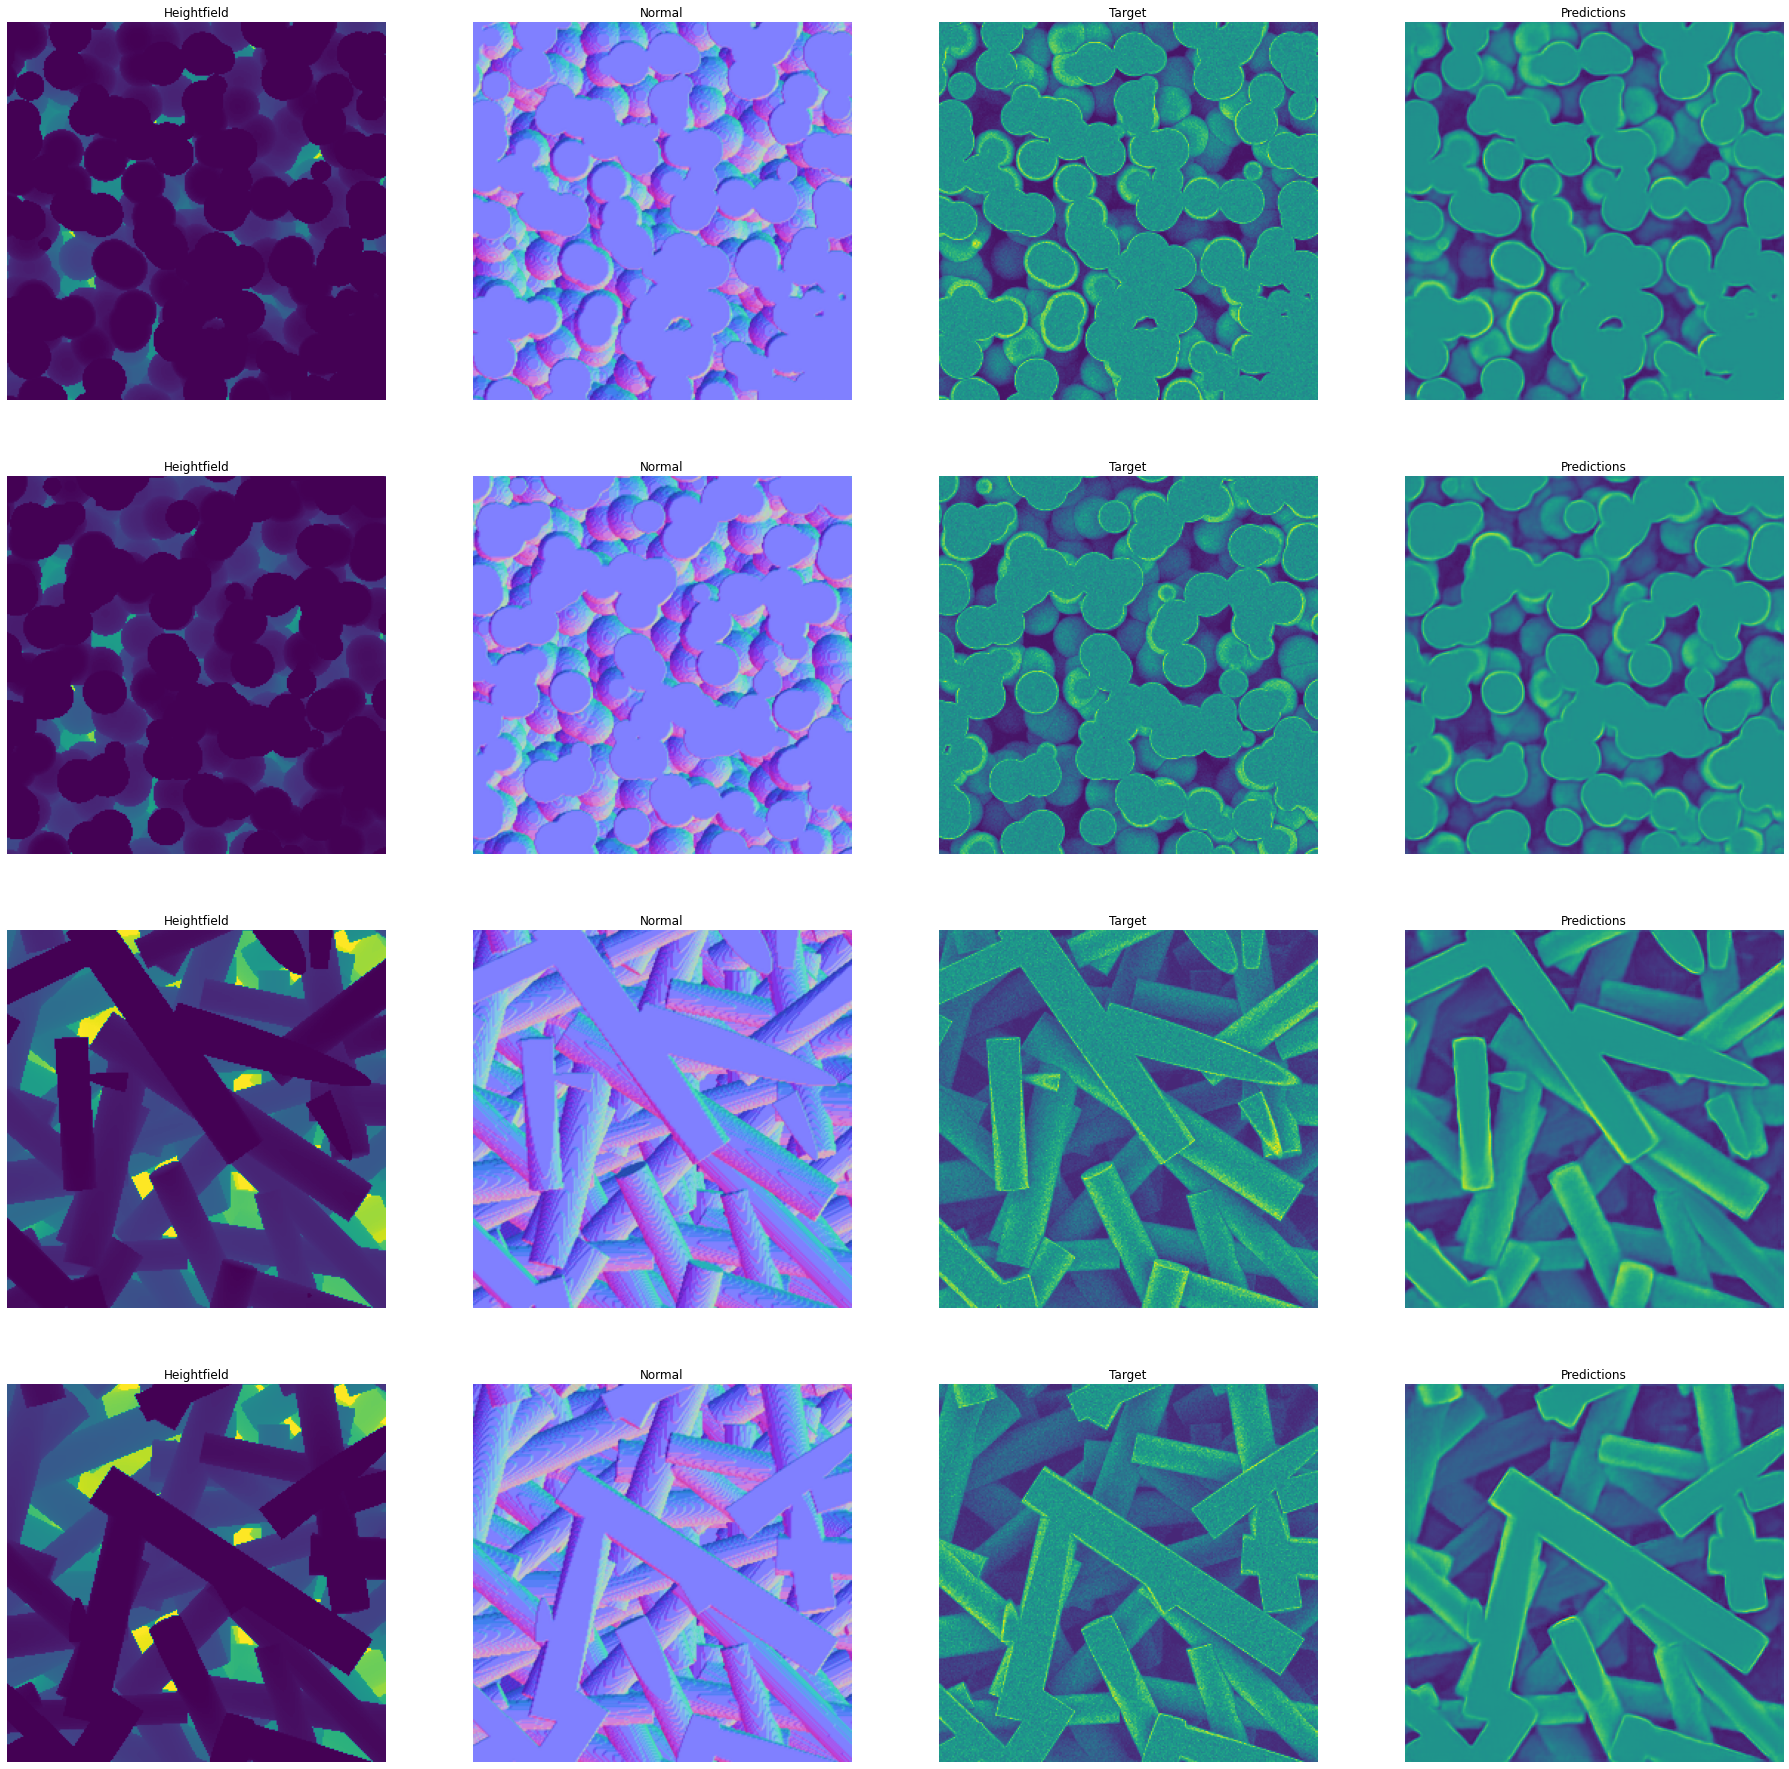

In [12]:
from torchvision.utils import save_image

interpretation = Interpretation.from_learner( learner )
values,indices = interpretation.top_losses(k=4)

fig, axs = plt.subplots(4, 4, figsize=(32,32))

for i,idx in enumerate(indices):
    inps, preds, targs, decoded, loss = interpretation[idx]
    inps_hf, inps_n = inps
    inps_hf = inps_hf[0,:,:,:]
    inps_n = inps_n[0,:,:,:]
    targs = targs[0,:,:,:]
    preds = preds[0,:,:,:]
    resid = preds - targs
    
    show_image( ax=axs[i,0], im=inps_hf,  title="Heightfield")
    show_image( ax=axs[i,1], im=inps_n,  title="Normal")
    show_image( ax=axs[i,2], im=targs, title="Target", vmin=0, vmax=1)
    show_image( ax=axs[i,3], im=preds, title="Predictions", vmin=0, vmax=1)

    #show_image( ax=axs[i,0], im=inps, title="Input")
    #show_image( ax=axs[i,1], im=targs, title="Target")
    #show_image( ax=axs[i,2], im=preds, title="Predictions")
    #show_image( ax=axs[i,3], im=resid, title="Residuals")
    # save_image(inps, "input_" + str(i) + ".png")
    save_image(targs, "target_" + str(i) + ".png")
    save_image(preds, "prediction_" + str(i) + ".png")
    # save_image(decoded, "decoded_" + str(i) + ".png")
# interpretation.show_results( indices, figsize=(64,64), vmin=0, vmax=128 )